# Comparison of CNNs with(out) Regularizations on SVHN dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import pickle

import utils
from MLP_model import MLP
from CNN_models import CNN, CNN_with_dropout

%load_ext autoreload
%autoreload 2

In [2]:
max_epoch = 40
scenarios = []

In [3]:
utils.set_random_seed(42)

In [4]:
dataset = dsets.SVHN(root='data/', download=True, transform=transforms.ToTensor())
testset = dsets.SVHN(root='data/', download=True, split="test", transform=transforms.ToTensor())

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [5]:
# We use about 20% of the dataset for validation.
val_size = 10000
train_size = len(dataset) - val_size
batch_size = 128

print("Single Sample Shape: ", dataset[0][0].size())

trainset, valset = random_split(dataset, [train_size, val_size])
print("Data sizes after random splitting -> \nTrain data size = {} \nValidation data size = {} \nTest data size = {}".format(len(trainset),len(valset), len(testset)))

train_loader = DataLoader(trainset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(valset, batch_size)
test_loader = DataLoader(testset, batch_size)

print("Total number of batches in one epoch (Train):", len(train_loader))
print("Total number of batches in one epoch (Validation):", len(val_loader))
print("Total number of batches in one epoch (Test):", len(test_loader))

Single Sample Shape:  torch.Size([3, 32, 32])
Data sizes after random splitting -> 
Train data size = 63257 
Validation data size = 10000 
Test data size = 26032
Total number of batches in one epoch (Train): 495
Total number of batches in one epoch (Validation): 79
Total number of batches in one epoch (Test): 204


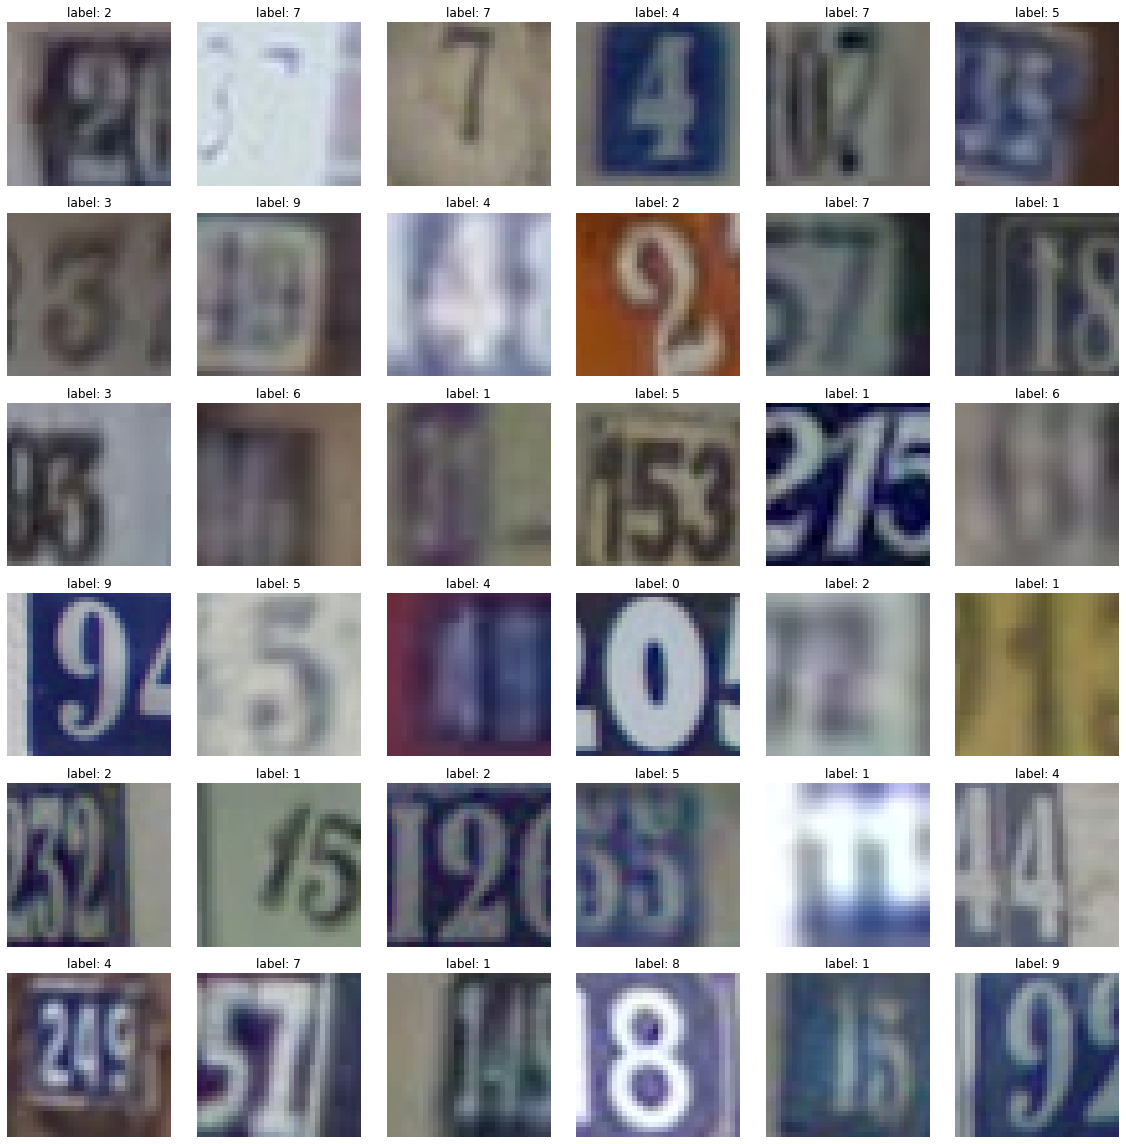

In [6]:
utils.visualize_data(trainset)

In [7]:
!nvidia-smi

Mon Nov 22 03:05:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0    33W /  N/A |   3489MiB / 16102MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Device is : cuda


In [9]:
def run_experiment(model, reg_params, reg_function, max_epoch, experiment_name, scenarios):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_function = torch.nn.CrossEntropyLoss()

    train_loss, train_acc, val_loss, val_acc = utils.train(model, 
                                                     train_loader, 
                                                     val_loader, 
                                                     optimizer, 
                                                     loss_function, 
                                                     reg_function=reg_function,
                                                     reg_params=reg_params,
                                                     max_epoch=max_epoch,
                                                     device=device)

    test_loss, test_acc, confusion_matrix = utils.evaluate(model, test_loader, loss_function, device=device)
    print("Test Loss : {} Test Acc: {}".format(test_loss, test_acc))

    utils.visualize_loss_acc(train_loss, val_loss, train_acc, val_acc)
    utils.visualize_confusion_matrix(confusion_matrix)

    scenarios.append((experiment_name, train_loss, train_acc, val_loss, val_acc, test_loss, test_acc))
    
    return scenarios

## Training CNN without Dropout

### No Regularization

epoch 39 train acc: 0.881 val acc: 0.8744 train loss: 0.4418 val loss: 0.4722: 1


Time:  192.5601818540017
Test Loss : 0.526127136148074 Test Acc: 0.8631152982026145


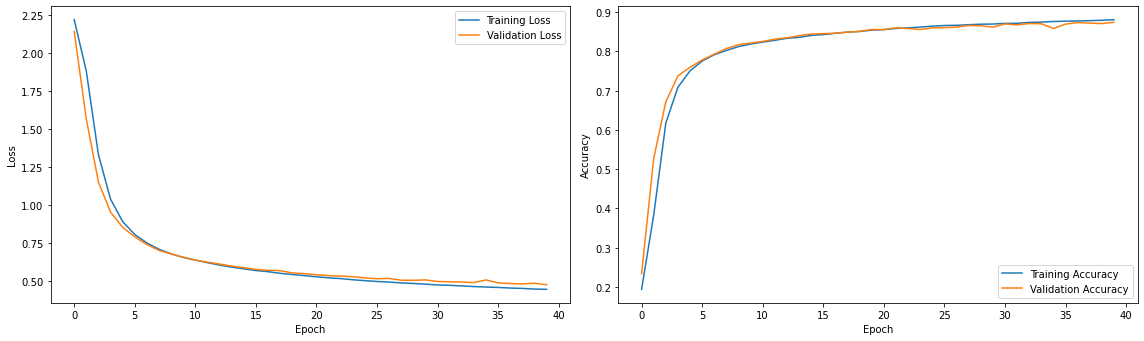

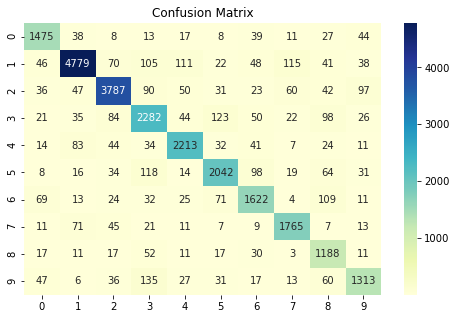

In [10]:
model = CNN().to(device)
reg_params = None
reg_function = None
experiment_name = "CNN - No Reg"

scenarios = run_experiment(model, reg_params, reg_function, max_epoch, experiment_name, scenarios)

### L1 Regularization

epoch 39 train acc: 0.8802 val acc: 0.8703 train loss: 0.4476 val loss: 0.4916: 


Time:  190.54397163001704
Test Loss : 0.5408330250750569 Test Acc: 0.8594388276143792


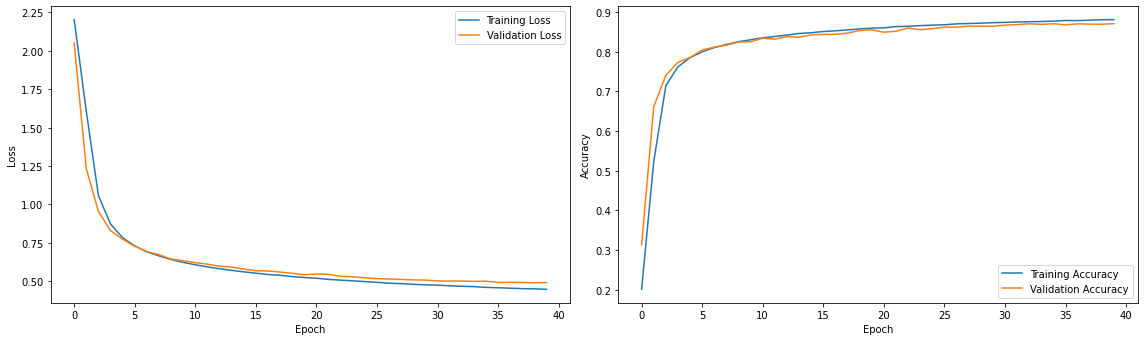

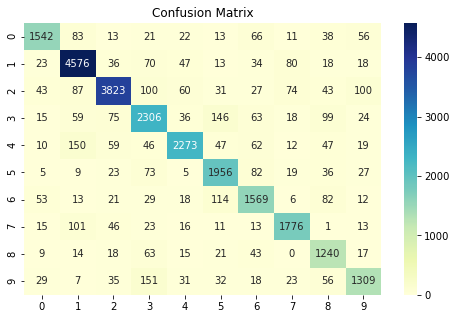

In [11]:
model = CNN().to(device)
reg_params = {"lambda1":0.00001}
reg_function = utils.L1_regularization
experiment_name = "CNN - L1 Reg"

scenarios = run_experiment(model, reg_params, reg_function, max_epoch, experiment_name, scenarios)

### L2 Regularization

epoch 39 train acc: 0.8835 val acc: 0.8749 train loss: 0.4332 val loss: 0.4743: 


Time:  203.58754328501527
Test Loss : 0.5267625960941408 Test Acc: 0.8616727941176471


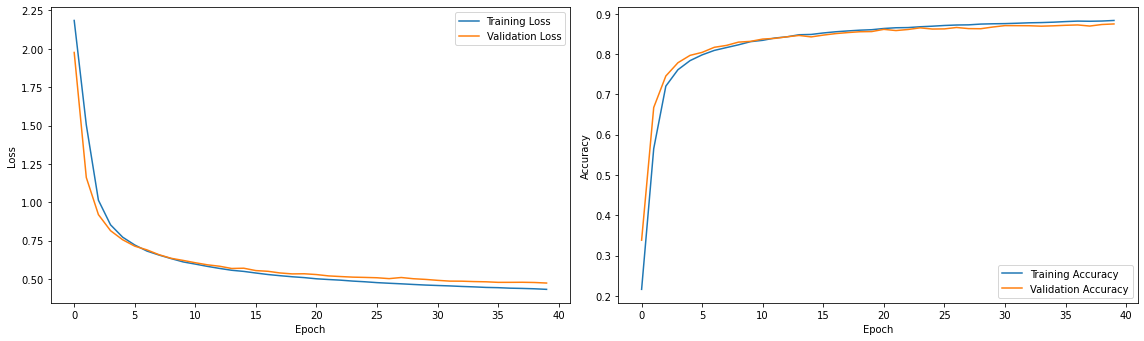

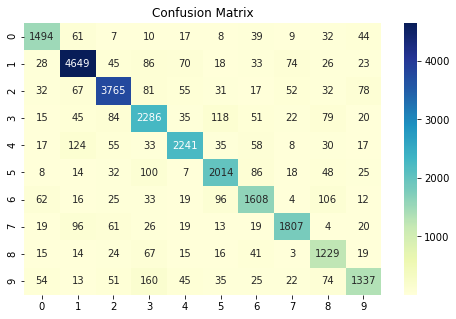

In [12]:
model = CNN().to(device)
reg_params = {"lambda2":0.001}
reg_function = utils.L2_regularization
experiment_name = "CNN - L2 Reg"

scenarios = run_experiment(model, reg_params, reg_function, max_epoch, experiment_name, scenarios)

### Elastic Regularization

epoch 39 train acc: 0.8761 val acc: 0.87 train loss: 0.46 val loss: 0.4966: 100%


Time:  213.77428819800843
Test Loss : 0.5421775105391063 Test Acc: 0.8607153799019608


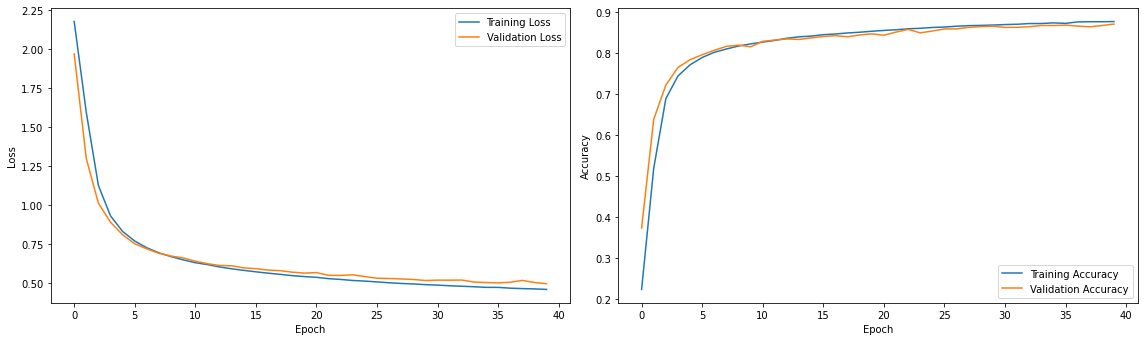

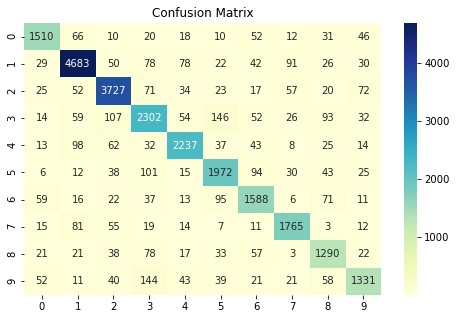

In [13]:
model = CNN().to(device)
reg_params = {"p":0.5, "lambda1":0.00001, "lambda2":0.001}
reg_function = utils.elastic_regularization
experiment_name = "CNN - Elastic Reg"

scenarios = run_experiment(model, reg_params, reg_function, max_epoch, experiment_name, scenarios)

## Training CNN with Dropout

### No Regularization

epoch 39 train acc: 0.8824 val acc: 0.8722 train loss: 0.4497 val loss: 0.5048: 


Time:  204.01992774300743
Test Loss : 0.5744440015040192 Test Acc: 0.8587111928104576


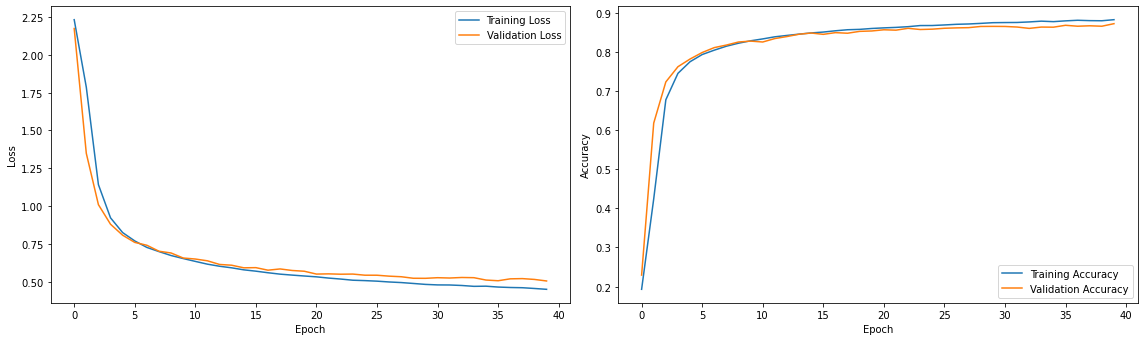

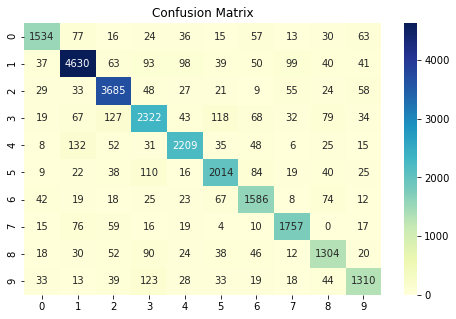

In [14]:
model = CNN_with_dropout().to(device)
reg_params = None
reg_function = None
experiment_name = "CNN Dropout - No Reg"

scenarios = run_experiment(model, reg_params, reg_function, max_epoch, experiment_name, scenarios)

### L1 Regularization

epoch 39 train acc: 0.8851 val acc: 0.8697 train loss: 0.4404 val loss: 0.5156: 


Time:  214.8390437560156
Test Loss : 0.5666715335466114 Test Acc: 0.860766441993464


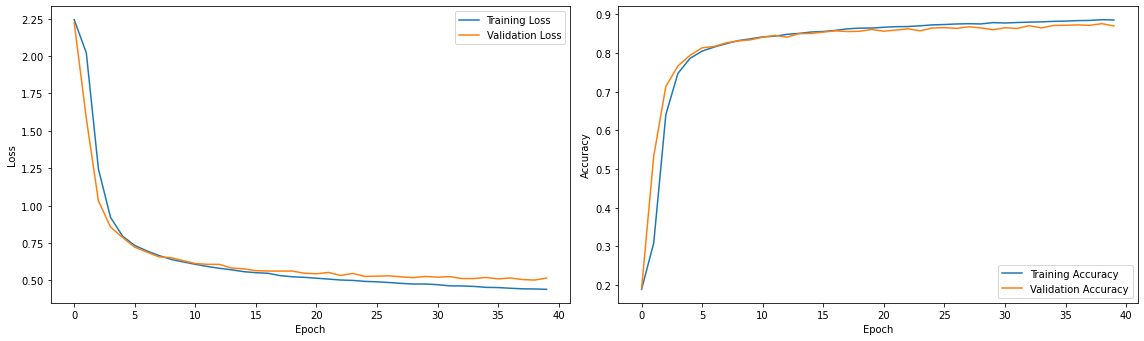

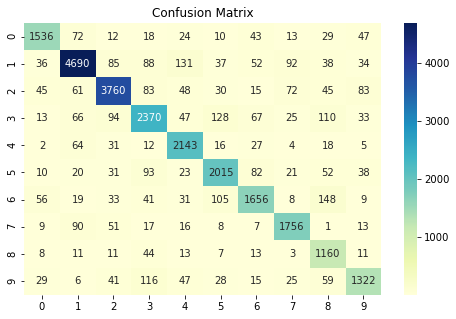

In [15]:
model = CNN_with_dropout().to(device)
reg_params = {"lambda1":0.00001}
reg_function = utils.L1_regularization
experiment_name = "CNN Dropout - L1 Reg"

scenarios = run_experiment(model, reg_params, reg_function, max_epoch, experiment_name, scenarios)

### L2 Regularization

epoch 39 train acc: 0.8846 val acc: 0.8664 train loss: 0.451 val loss: 0.5079: 1


Time:  198.96604974198272
Test Loss : 0.5767271588830387 Test Acc: 0.8612387663398693


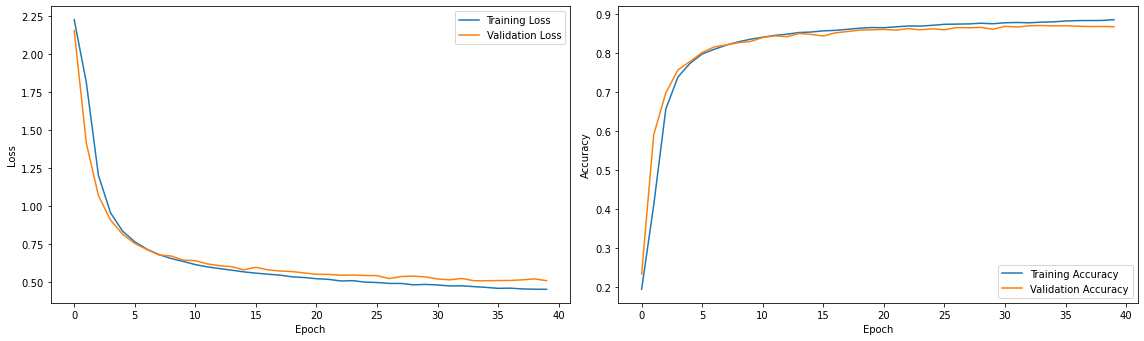

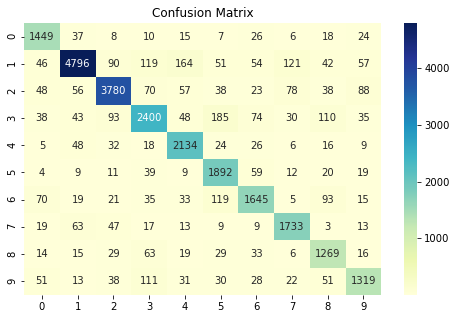

In [16]:
model = CNN_with_dropout().to(device)
reg_params = {"lambda2":0.001}
reg_function = utils.L2_regularization
experiment_name = "CNN Dropout - L2 Reg"

scenarios = run_experiment(model, reg_params, reg_function, max_epoch, experiment_name, scenarios)

### Elastic Regularization

epoch 39 train acc: 0.8829 val acc: 0.869 train loss: 0.4498 val loss: 0.5134: 1


Time:  202.72140512499027
Test Loss : 0.5747115891061577 Test Acc: 0.859515420751634


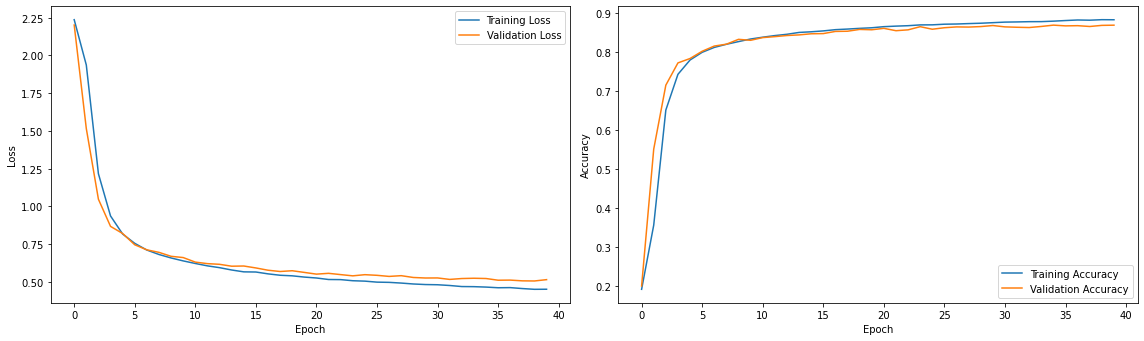

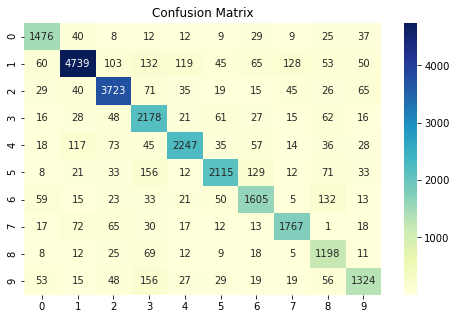

In [17]:
model = CNN_with_dropout().to(device)
reg_params = {"p":0.5, "lambda1":0.00001, "lambda2":0.001}
reg_function=utils.elastic_regularization
experiment_name = "CNN Dropout - Elastic Reg"

scenarios = run_experiment(model, reg_params, reg_function, max_epoch, experiment_name, scenarios)

## Plot & Compare All Scenarios

CNN - No Reg Test Accuracy: 0.863
CNN - L1 Reg Test Accuracy: 0.859
CNN - L2 Reg Test Accuracy: 0.862
CNN - Elastic Reg Test Accuracy: 0.861
CNN Dropout - No Reg Test Accuracy: 0.859
CNN Dropout - L1 Reg Test Accuracy: 0.861
CNN Dropout - L2 Reg Test Accuracy: 0.861
CNN Dropout - Elastic Reg Test Accuracy: 0.86


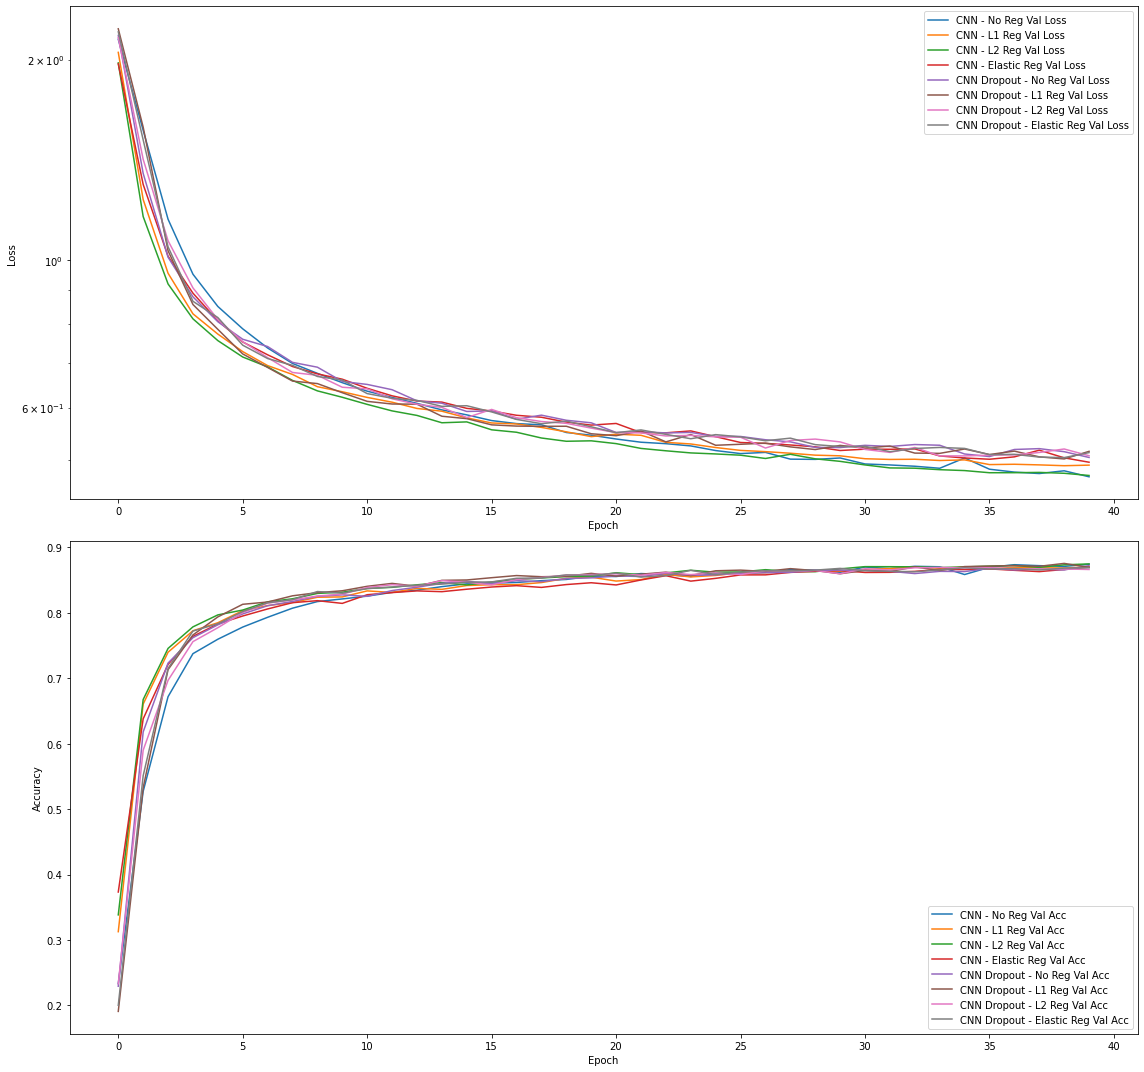

In [19]:
utils.plot_all(scenarios)

In [20]:
pickle.dump(scenarios, open( "CNNs_scenarios.p", "wb" ) )